# Forecasting with SARIMA

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from pandas.tseries.offsets import DateOffset

c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("merged_df.csv", parse_dates=["DATE"])

### RUN MODELS

In [3]:
# model settings
order = (1,1,1)
seasonal_order = (1,1,1,12)
forecast_end = pd.to_datetime("2030-12-01")

# containers
forecasts_exog = []
forecasts_noex  = []
forecasts_prop  = []

In [4]:
for znr, grp in df.groupby("ZNR"):
    grp = grp.set_index("DATE").sort_index()
    # split history vs future
    hist = grp[grp["DTVMS"].notna()]
    last = hist.index.max()
    future_idx = pd.date_range(last + DateOffset(months=1), forecast_end, freq="MS")
    if len(hist) < 24:
        continue

    # 1) SARIMAX with exog
    exog_cols = ["AUSPENDLER","POP","PKW_DENSITY",
                 "BICYCLE","BIKESHARING","BY_FOOT",
                 "CAR","CARSHARING","MOTORBIKE","PUBLIC_TRANSPORT",
                 "ISTCOVID19"]
    exog_hist = hist[exog_cols].fillna(0)
    exog_future = grp.reindex(future_idx)[exog_cols].fillna(0)
    model_ex = SARIMAX(hist["DTVMS"], exog=exog_hist,
                       order=order, seasonal_order=seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False)
    res_ex = model_ex.fit(disp=False)
    pred_ex = res_ex.get_forecast(steps=len(future_idx), exog=exog_future)
    fe = pd.DataFrame({
        "ZNR": znr,
        "DATE": future_idx,
        "DTVMS_fc_exog": pred_ex.predicted_mean
    })
    forecasts_exog.append(fe)

    # 2) SARIMAX without exog (pure SARIMA)
    model_no = SARIMAX(hist["DTVMS"],
                       order=order, seasonal_order=seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False)
    res_no = model_no.fit(disp=False)
    pred_no = res_no.get_forecast(steps=len(future_idx))
    fn = pd.DataFrame({
        "ZNR": znr,
        "DATE": future_idx,
        "DTVMS_fc_noex": pred_no.predicted_mean
    })
    forecasts_noex.append(fn)

    # 3) Prophet model
    # prepare df for Prophet
    df_prop = hist[["DTVMS"]].reset_index().rename(columns={"DATE":"ds","DTVMS":"y"})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    # add exogenous as extra regressors
    for col in exog_cols:
        df_prop[col] = hist[col].values
        m.add_regressor(col)
    m.fit(df_prop)
    future_prop = m.make_future_dataframe(periods=len(future_idx), freq="MS")
    # merge exog into future_prop
    future_prop = future_prop.merge(
        grp[exog_cols].reset_index().rename(columns={"DATE":"ds"}),
        on="ds", how="left"
    ).fillna(0)
    fc_prop = m.predict(future_prop)
    fp = fc_prop[["ds","yhat"]].tail(len(future_idx))
    fp["ZNR"] = znr
    fp = fp.rename(columns={"ds":"DATE","yhat":"DTVMS_fc_prophet"})
    forecasts_prop.append(fp[["ZNR","DATE","DTVMS_fc_prophet"]])

c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
16:44:48 - cmdstanpy

#### Combine Forecast Data

In [5]:
# combine and save
out_ex = pd.concat(forecasts_exog, ignore_index=True)
out_no = pd.concat(forecasts_noex,  ignore_index=True)
out_pr = pd.concat(forecasts_prop,  ignore_index=True)

out = (out_ex
       .merge(out_no, on=["ZNR","DATE"])
       .merge(out_pr, on=["ZNR","DATE"]))
out.to_csv("all_counters_forecasts.csv", index=False)

In [6]:

# 1) Load your combined forecast DataFrame
out = pd.read_csv("all_counters_forecasts.csv", parse_dates=["DATE"])

# 2) Determine the set of ZNR and expected months
znrs      = out["ZNR"].unique()
dates     = pd.date_range("2025-01-01", "2030-12-01", freq="MS")
expected  = pd.MultiIndex.from_product([znrs, dates], names=["ZNR","DATE"])

# 3) Build an index of your actual forecasts
actual_idx = pd.MultiIndex.from_frame(out[["ZNR","DATE"]])

# 4) Compute the missing (ZNR,DATE) pairs
missing = expected.difference(actual_idx)

print(f"Total expected rows: {len(expected)}")
print(f"Total actual   rows: {len(actual_idx)}")
print(f"Missing rows:       {len(missing)}")

if len(missing) == 0:
    print("✅ All counters have a forecast for every month 2025-2030.")
else:
    # show a sample of the first few missing entries
    print("❌ Some forecasts are missing:")
    print(pd.DataFrame(list(missing), columns=["ZNR","DATE"]).head())

Total expected rows: 4392
Total actual   rows: 4392
Missing rows:       0
✅ All counters have a forecast for every month 2025-2030.


### Combine with original df

In [8]:
import pandas as pd

# 1) Load your full panel (with historical DTVMS up to last_obs and exog for all months)
panel = pd.read_csv("merged_df.csv", parse_dates=["DATE"])
# panel must have columns: ZNR, DATE, DTVMS  (NaN after last historical month)

# 2) Load your forecasts
fc = pd.read_csv("all_counters_forecasts.csv", parse_dates=["DATE"])
# must have: ZNR, DATE, DTVMS_fc_exog, DTVMS_fc_noex, DTVMS_fc_prophet

# 3) Merge them
df = (panel
      .merge(fc, on=["ZNR","DATE"], how="left")
     )

# 4) Build full series for each method:
#    - where historical exists, keep it; otherwise take the forecast
df["DTVMS_full_exog"]   = df["DTVMS"].fillna(df["DTVMS_fc_exog"])
df["DTVMS_full_noex"]   = df["DTVMS"].fillna(df["DTVMS_fc_noex"])
df["DTVMS_full_prophet"]= df["DTVMS"].fillna(df["DTVMS_fc_prophet"])

# 5) (Optional) sanity-check: make sure no NaNs remain in 2025–2030 for each
future_mask = df["DATE"] >= "2025-01-01"
for col in ["DTVMS_full_exog","DTVMS_full_noex","DTVMS_full_prophet"]:
    n_missing = df.loc[future_mask, col].isna().sum()
    print(f"{col} missing in future: {n_missing}")

# 6) Save or continue working with `df`
df.to_csv("traffic_with_full_series.csv", index=False)


DTVMS_full_exog missing in future: 0
DTVMS_full_noex missing in future: 0
DTVMS_full_prophet missing in future: 0


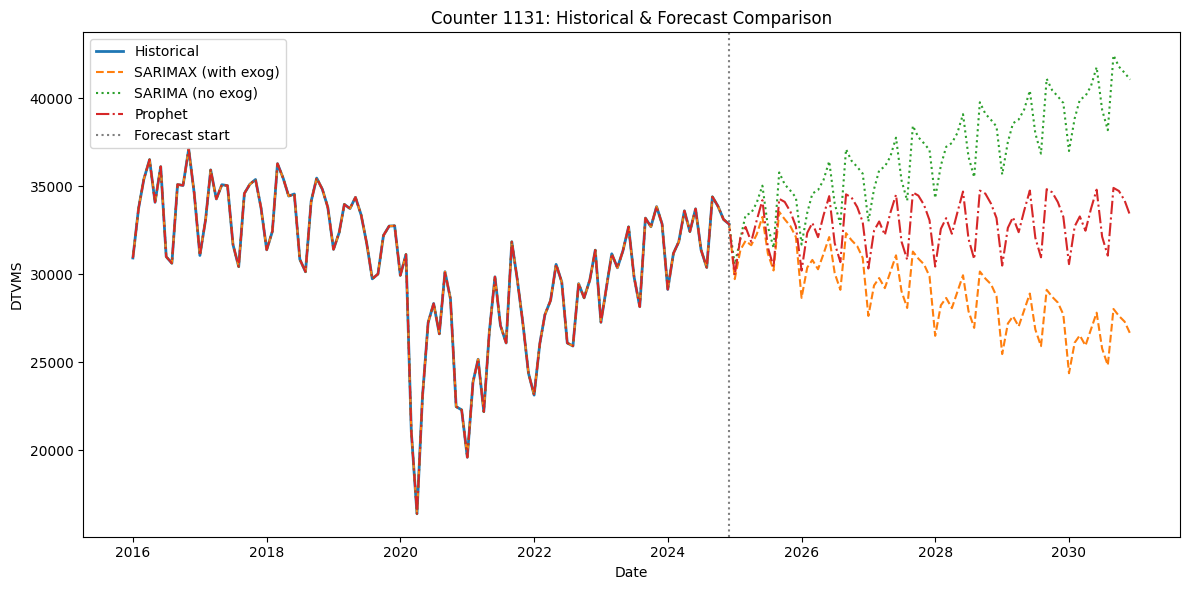

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load your full series with forecasts
df = pd.read_csv("traffic_with_full_series.csv", parse_dates=["DATE"])

# 2) Filter to a single counter, e.g. ZNR 1075
znr = 1131
sub = df[df["ZNR"] == znr].set_index("DATE").sort_index()

# 3) Find the last historical date
last_hist = sub["DTVMS"].last_valid_index()

# 4) Plot historical vs. forecasts
plt.figure(figsize=(12, 6))
plt.plot(sub.index, sub["DTVMS"],            label="Historical",          linewidth=2)
plt.plot(sub.index, sub["DTVMS_full_exog"],   label="SARIMAX (with exog)", linestyle="--")
plt.plot(sub.index, sub["DTVMS_full_noex"],   label="SARIMA (no exog)",     linestyle=":")
plt.plot(sub.index, sub["DTVMS_full_prophet"],label="Prophet",              linestyle="-.")

# vertical line at forecast start
plt.axvline(last_hist, color="gray", linestyle=":", label="Forecast start")

plt.title(f"Counter {znr}: Historical & Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("DTVMS")
plt.legend()
plt.tight_layout()
plt.show()

## Backtest because of wide margins

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from pandas.tseries.offsets import DateOffset

# 1) Load your full panel (historical DTVMS + exogs + full‐series forecasts)
df = pd.read_csv("traffic_with_full_series.csv", parse_dates=["DATE"])
df = df.sort_values(["ZNR","DATE"]).reset_index(drop=True)

# 2) Define train/test split
train_end  = pd.to_datetime("2022-12-01")
test_start = train_end + DateOffset(months=1)
test_end   = pd.to_datetime("2024-12-01")

# 3) Your exogenous columns
exog_cols = [
    "AUSPENDLER","POP","PKW_DENSITY",
    "BICYCLE","BIKESHARING","BY_FOOT",
    "CAR","CARSHARING","MOTORBIKE","PUBLIC_TRANSPORT",
    "ISTCOVID19"
]

errs = []
for znr, grp in df.groupby("ZNR"):
    grp = grp.set_index("DATE").sort_index()
    # skip if fewer than 36 historical points
    if grp["DTVMS"].loc[:train_end].dropna().shape[0] < 36:
        continue

    # split into train / test
    train = grp.loc[:train_end]
    test  = grp.loc[test_start:test_end]

    y_train = train["DTVMS"]
    y_test  = test["DTVMS"]

    # --- SARIMAX with exog ---
    exog_train = train[exog_cols].fillna(0)
    exog_test  = test[exog_cols].fillna(0)
    m_ex = SARIMAX(
        y_train, exog=exog_train,
        order=(1,1,1), seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    yhat_ex = m_ex.predict(start=test_start, end=test_end, exog=exog_test)

    # --- SARIMA (no exog) ---
    m_no = SARIMAX(
        y_train,
        order=(1,1,1), seasonal_order=(1,1,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    yhat_no = m_no.predict(start=test_start, end=test_end)

    # --- Prophet with regressors ---
    #  a) build history df
    df_prop = (
        train.reset_index()[["DATE","DTVMS"]]
        .rename(columns={"DATE":"ds","DTVMS":"y"})
    )
    #  b) add each exogenous regressor
    for col in exog_cols:
        df_prop[col] = train[col].values
    #  c) fit
    m_pr = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    for col in exog_cols:
        m_pr.add_regressor(col)
    m_pr.fit(df_prop)
    #  d) make future frame & merge exogs
    future = m_pr.make_future_dataframe(
        periods=len(y_test), freq="MS"
    )
    future = future.merge(
        grp[exog_cols].reset_index().rename(columns={"DATE":"ds"}),
        on="ds", how="left"
    ).fillna(0)
    fc = m_pr.predict(future)
    yhat_pr = fc.set_index("ds")["yhat"].loc[test_start:test_end]

    # compute RMSE for each
    rmse_ex = np.sqrt(mean_squared_error(y_test, yhat_ex))
    rmse_no = np.sqrt(mean_squared_error(y_test, yhat_no))
    rmse_pr = np.sqrt(mean_squared_error(y_test, yhat_pr))

    errs.append({
        "ZNR": znr,
        "rmse_exog":   rmse_ex,
        "rmse_noex":   rmse_no,
        "rmse_prophet":rmse_pr
    })

# 4) Gather results
err_df = pd.DataFrame(errs)
print("Per-counter RMSEs:\n", err_df)

# 5) Overall average RMSE
overall = err_df[["rmse_exog","rmse_noex","rmse_prophet"]].mean()
print("\nOverall mean RMSE:\n", overall)

# 6) Inverse-RMSE weights
w = 1/overall
w = w / w.sum()
print("\nInverse-RMSE ensemble weights:\n", w)

# You can then ensemble like:
# df["DTVMS_ensemble_wt"] = (
#     df["DTVMS_full_exog"] * w["rmse_exog"] +
#     df["DTVMS_full_noex"] * w["rmse_noex"] +
#     df["DTVMS_full_prophet"] * w["rmse_prophet"]
# )


c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mihim\Desktop\PythonUSDataProject\ds_lab_project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
17:19:15 - cmdstanpy

Per-counter RMSEs:
      ZNR      rmse_exog     rmse_noex  rmse_prophet
0   1075   9.905076e+04  2.161538e+03   8561.773783
1   1078   1.962010e+03  2.555261e+03  12722.657727
2   1089   4.716402e+03  1.661022e+03   8230.701908
3   1096   6.470864e+03  1.700210e+03   9521.055680
4   1131   7.180209e+03  3.562511e+03  24230.838957
..   ...            ...           ...           ...
56  1623   3.932471e+04  1.559377e+03   1153.886765
57  1624   6.346820e+02  5.807580e+02   1887.239814
58  1625   2.679112e+06  7.429250e+03   2780.957892
59  1626   3.016021e+76  2.503639e+12   5934.939536
60  1627  7.810396e+117  1.005670e+04  18672.685563

[61 rows x 4 columns]

Overall mean RMSE:
 rmse_exog       1.280393e+116
rmse_noex        6.074400e+40
rmse_prophet     5.612738e+03
dtype: float64

Inverse-RMSE ensemble weights:
 rmse_exog       4.383607e-113
rmse_noex        9.239989e-38
rmse_prophet     1.000000e+00
dtype: float64


In [46]:
# 1) compute the 99th percentile for each column
cuts = err_df[["rmse_exog","rmse_noex","rmse_prophet"]].quantile(0.95)
print("95th-percentile RMSE cutoffs:\n", cuts)

# 2) filter out any ZNR where *any* RMSE > its cutoff
good = err_df[
    (err_df["rmse_exog"]   <= cuts["rmse_exog"])   &
    (err_df["rmse_noex"]   <= cuts["rmse_noex"])   &
    (err_df["rmse_prophet"]<= cuts["rmse_prophet"])
].copy()
print(f"\nKept {len(good)} out of {len(err_df)} counters for ensemble.")

# 3) recompute overall mean RMSE on this trimmed set
overall_trimmed = good[["rmse_exog","rmse_noex","rmse_prophet"]].mean()
print("\nTrimmed overall mean RMSE:\n", overall_trimmed)

# 4) build new inverse-RMSE weights
w_trimmed = 1/overall_trimmed
w_trimmed = w_trimmed / w_trimmed.sum()
print("\nTrimmed inverse-RMSE ensemble weights:\n", w_trimmed)

# 5) (optionally) if you want to drop those ZNR entirely from your final dataset:
z_drop = err_df.loc[~err_df["ZNR"].isin(good["ZNR"]), "ZNR"].tolist()
print("\nDrop these counters from final ensemble:", z_drop)

95th-percentile RMSE cutoffs:
 rmse_exog       2.679112e+06
rmse_noex       3.378355e+04
rmse_prophet    2.312254e+04
Name: 0.95, dtype: float64

Kept 53 out of 61 counters for ensemble.

Trimmed overall mean RMSE:
 rmse_exog       62003.736780
rmse_noex        1578.701811
rmse_prophet     3641.129221
dtype: float64

Trimmed inverse-RMSE ensemble weights:
 rmse_exog       0.017451
rmse_noex       0.685384
rmse_prophet    0.297165
dtype: float64

Drop these counters from final ensemble: [1131, 1170, 1220, 1221, 1223, 1224, 1626, 1627]


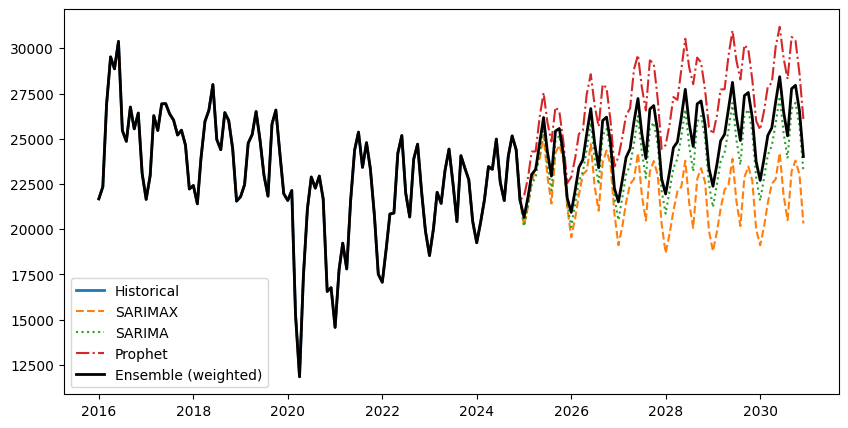

In [ ]:
# 1) Load your full dataset with the three full‐series forecasts
df = pd.read_csv("traffic_with_full_series.csv", parse_dates=["DATE"])

# 2) Drop the “bad” counters we trimmed out
drop_z = [1131, 1170, 1220, 1221, 1223, 1224, 1626, 1627]
df = df[~df["ZNR"].isin(drop_z)].copy()

# 3) Define your trimmed weights
w_ex  = 0.017451    # SARIMAX (with exog)
w_no  = 0.685384    # SARIMA (no exog)
w_pr  = 0.297165    # Prophet

# 4) Compute your final weighted‐ensemble series
df["DTVMS_ensemble"] = (
    df["DTVMS_full_exog"]   * w_ex +
    df["DTVMS_full_noex"]   * w_no +
    df["DTVMS_full_prophet"]* w_pr
)

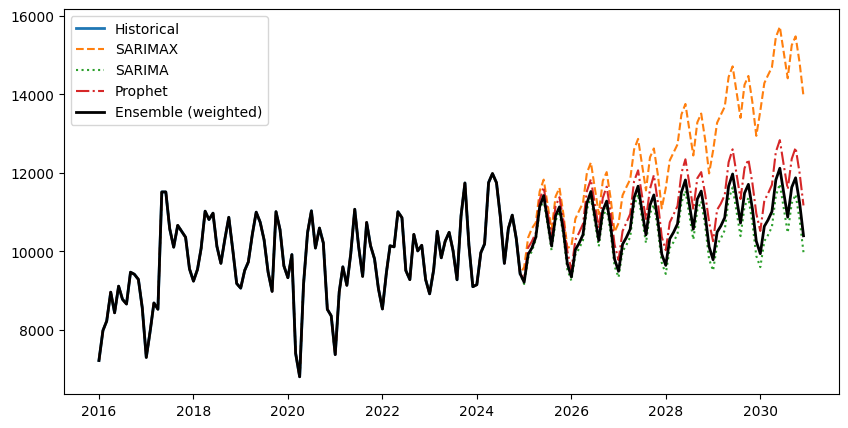

In [50]:
znr = 1184
sub = df[df["ZNR"]==znr].set_index("DATE").sort_index()
plt.figure(figsize=(10,5))
plt.plot(sub["DTVMS"],            label="Historical",          linewidth=2)
plt.plot(sub["DTVMS_full_exog"],  label="SARIMAX",            linestyle="--")
plt.plot(sub["DTVMS_full_noex"],  label="SARIMA",             linestyle=":")
plt.plot(sub["DTVMS_full_prophet"], label="Prophet",           linestyle="-.")
plt.plot(sub["DTVMS_ensemble"],   label="Ensemble (weighted)", color="k", linewidth=2)
#plt.axvline("2024-12-01", color="gray", linestyle=":")
plt.legend(); plt.show()

# 6) Save your final results
df.to_csv("final_traffic_ensemble.csv", index=False)